<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/RTML_RNNregression_WithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
# Load data

data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [3]:
# Calculate speed and distances
epsilon = 1e-5  # Small constant to avoid division by zero
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + epsilon)

In [4]:
# Handle potential infinite or NaN values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)  # Fill NaNs with the mean of the column


In [5]:
# Normalize features
scaler = MinMaxScaler()
data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']] = scaler.fit_transform(
    data[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']]
)

In [6]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps + 1
        if end_ix > len(data):
            break
        seq_x = data.iloc[i:end_ix-1].to_numpy()
        seq_y = data.iloc[end_ix-1][['Latitude', 'Longitude']].to_numpy()
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Prepare sequences
grouped = data.groupby('Tag')
X, y = [], []
for _, group in grouped:
    sequences = create_sequences(group[['Latitude', 'Longitude', 'Lat_diff', 'Lon_diff', 'Speed']], n_steps=5)
    X.append(sequences[0])
    y.append(sequences[1])

X = np.concatenate(X)
y = np.concatenate(y)


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size , hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        h = encoder_outputs
        energy = torch.tanh(self.attn(h))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class LSTMModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        lstm_out, _ = self.lstm(x)
        attention_weights = self.attention(lstm_out)
        context = torch.bmm(attention_weights.unsqueeze(1), lstm_out).squeeze(1)
        output = self.fc(context)
        return output

model = LSTMModel(hidden_size=128).to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()




Epoch 1: Training Loss: 0.0008979274456006925, Validation Loss: 2.912601091871357e-05
Epoch 2: Training Loss: 2.4926249070150777e-05, Validation Loss: 1.9322391798274673e-05
Epoch 3: Training Loss: 1.7918967296605048e-05, Validation Loss: 1.2600821875149893e-05
Epoch 4: Training Loss: 1.538066573096514e-05, Validation Loss: 9.641388430784185e-06
Epoch 5: Training Loss: 1.4881454068524675e-05, Validation Loss: 1.2647397206720958e-05
Epoch 6: Training Loss: 1.3334497710518173e-05, Validation Loss: 1.947909445984156e-05
Epoch 7: Training Loss: 1.3053305291461533e-05, Validation Loss: 1.8196164090412963e-05
Epoch 8: Training Loss: 1.2611755570409351e-05, Validation Loss: 9.919337586589542e-06
Epoch 9: Training Loss: 1.2371834071262334e-05, Validation Loss: 1.633172391092335e-05
Epoch 10: Training Loss: 1.2186274470780937e-05, Validation Loss: 1.4555640805874167e-05
Epoch 11: Training Loss: 1.1978561823462257e-05, Validation Loss: 1.4379307759587321e-05
Epoch 12: Training Loss: 1.1572380451

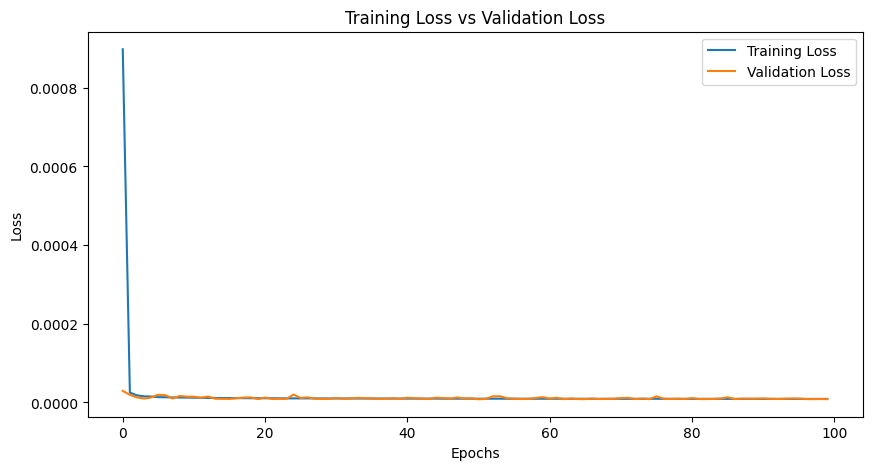

In [12]:
# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)

In [15]:
# Load Model Function
def load_model(model, load_path='model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model

Actual: [-13.047427  33.095512], Predicted: [-13.046017  33.097137]
Actual: [-12.790285  33.230587], Predicted: [-12.784341  33.232067]
Actual: [-12.711675  33.07353 ], Predicted: [-12.709572  33.074467]
Actual: [-12.832457  33.127335], Predicted: [-12.831151  33.129086]
Actual: [-12.897855  33.201393], Predicted: [-12.897046  33.20206 ]
Actual: [-12.88683   33.272457], Predicted: [-12.882152  33.26662 ]
Actual: [-12.896598  33.22662 ], Predicted: [-12.897151  33.227673]
Actual: [-12.867208  33.252605], Predicted: [-12.866732  33.25243 ]
Actual: [-13.024735  33.23061 ], Predicted: [-13.023751  33.23339 ]
Actual: [-12.868487  33.26492 ], Predicted: [-12.871619  33.26513 ]

Average Loss: 8.228997163882827e-06
 RMSE: 0.058690015226602554


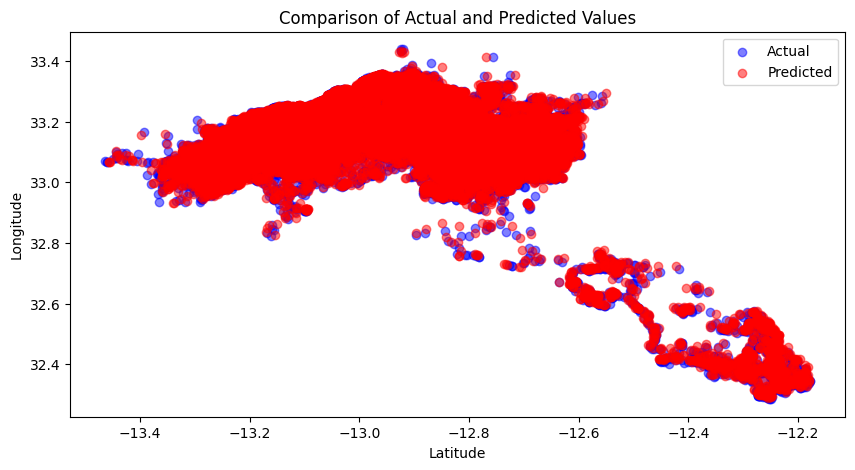

In [16]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    errors = []
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

                # Calculate RMSE for latitude and longitude combined
                error = np.sqrt(np.sum((actual[:2] - predicted[:2])**2))
                errors.append(error)

    avg_loss = total_loss / len(dataloader)
    avg_rmse = np.sqrt(np.mean(errors))

    print(f'\nAverage Loss: {avg_loss}')
    print(f' RMSE: {avg_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [17]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class RNNModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.rnn = nn.RNN(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        rnn_out, _ = self.rnn(x)
        attention_weights = self.attention(rnn_out)
        context = torch.bmm(attention_weights.unsqueeze(1), rnn_out).squeeze(1)
        output = self.fc(context)
        return output

rnn_model = RNNModel(hidden_size=128).to('cuda')
criterion_rnn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.834550580238731e-06, Validation Loss: 8.483155373194354e-06
Epoch 2: Training Loss: 8.819756185828677e-06, Validation Loss: 8.657659539037842e-06
Epoch 3: Training Loss: 8.821037677115462e-06, Validation Loss: 1.955632571560777e-05
Epoch 4: Training Loss: 8.859682135777676e-06, Validation Loss: 8.782809555093614e-06
Epoch 5: Training Loss: 8.842236940212365e-06, Validation Loss: 9.303414642721905e-06
Epoch 6: Training Loss: 8.791502848006135e-06, Validation Loss: 9.575989938149318e-06
Epoch 7: Training Loss: 8.751677820952737e-06, Validation Loss: 8.585882734795699e-06
Epoch 8: Training Loss: 8.805398045789739e-06, Validation Loss: 8.486823340062862e-06
Epoch 9: Training Loss: 8.781899915328741e-06, Validation Loss: 8.894202363957517e-06
Epoch 10: Training Loss: 8.805186119654763e-06, Validation Loss: 8.385579834073742e-06
Epoch 11: Training Loss: 8.77891608260621e-06, Validation Loss: 8.148977755992143e-06
Epoch 12: Training Loss: 8.753643460059689e-06, Valid

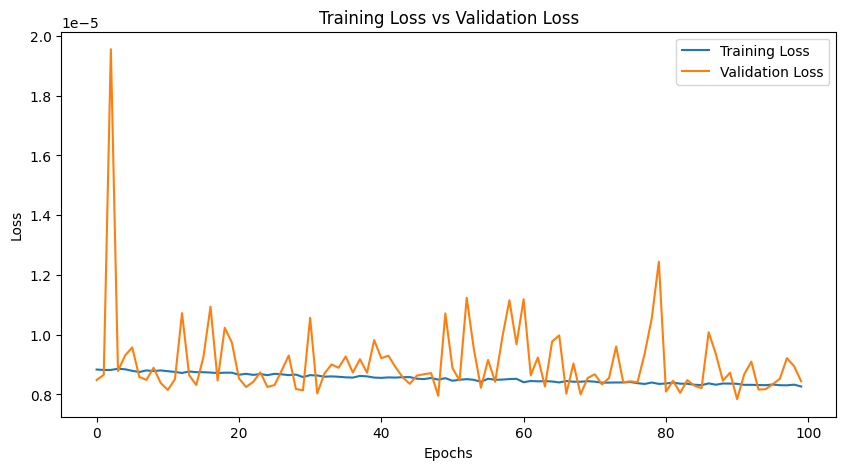

In [18]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_SimpleRNN.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_SimpleRNN.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.90168   33.304497], Predicted: [-12.9023905  33.297398 ]
Actual: [-13.029982  33.29644 ], Predicted: [-13.028299  33.29928 ]
Actual: [-13.118703  33.13329 ], Predicted: [-13.116478  33.133533]
Actual: [-12.85585   33.264343], Predicted: [-12.857739  33.264175]
Actual: [-12.854888  33.10686 ], Predicted: [-12.854308  33.106304]
Actual: [-12.880608  33.234737], Predicted: [-12.874687  33.224026]
Actual: [-12.811612  33.200798], Predicted: [-12.814389  33.2026  ]
Actual: [-12.867573  33.26665 ], Predicted: [-12.87026  33.26307]
Actual: [-12.928633  33.296913], Predicted: [-12.928369  33.29556 ]
Actual: [-13.184363  33.171646], Predicted: [-13.192658  33.16815 ]

Average Loss: 8.439904611937312e-06
 RMSE: 0.059869248420000076


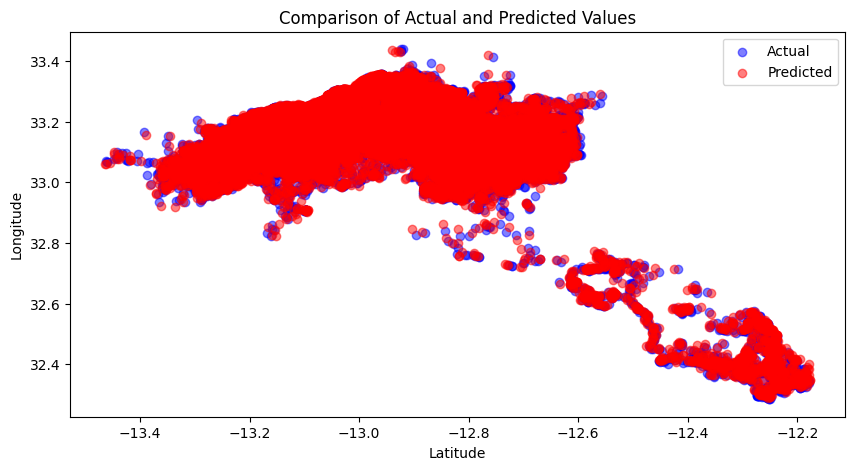

In [19]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    errors = []
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

                # Calculate RMSE for latitude and longitude combined
                error = np.sqrt(np.sum((actual[:2] - predicted[:2])**2))
                errors.append(error)

    avg_loss = total_loss / len(dataloader)
    avg_rmse = np.sqrt(np.mean(errors))

    print(f'\nAverage Loss: {avg_loss}')
    print(f' RMSE: {avg_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)


In [20]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, encoder_outputs):
        seq_len = encoder_outputs.size(1)
        energy = torch.tanh(self.attn(encoder_outputs))
        attention_scores = self.v(energy).squeeze(2)
        return torch.softmax(attention_scores, dim=1)

class GRUModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(5, 32)
        self.gru = nn.GRU(input_size=32, hidden_size=hidden_size, num_layers=3, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.fc1(x)
        gru_out, _ = self.gru(x)
        attention_weights = self.attention(gru_out)
        context = torch.bmm(attention_weights.unsqueeze(1), gru_out).squeeze(1)
        output = self.fc(context)
        return output

gru_model = GRUModel(hidden_size=128).to('cuda')
criterion_gru = nn.MSELoss()
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=0.001)


Epoch 1: Training Loss: 8.31380908206615e-06, Validation Loss: 8.186588514369532e-06
Epoch 2: Training Loss: 8.28720237713395e-06, Validation Loss: 8.617323648464805e-06
Epoch 3: Training Loss: 8.30976925721753e-06, Validation Loss: 8.392316874097523e-06
Epoch 4: Training Loss: 8.288126049560474e-06, Validation Loss: 8.230322147410531e-06
Epoch 5: Training Loss: 8.261919561863017e-06, Validation Loss: 8.299394605248013e-06
Epoch 6: Training Loss: 8.253674380140209e-06, Validation Loss: 8.713485852194062e-06
Epoch 7: Training Loss: 8.275392450164295e-06, Validation Loss: 8.393569719195217e-06
Epoch 8: Training Loss: 8.22163025847356e-06, Validation Loss: 7.955822401084286e-06
Epoch 9: Training Loss: 8.251350608495171e-06, Validation Loss: 9.722835649240463e-06
Epoch 10: Training Loss: 8.205673990424266e-06, Validation Loss: 8.077234304068029e-06
Epoch 11: Training Loss: 8.234468259245338e-06, Validation Loss: 8.386133272996948e-06
Epoch 12: Training Loss: 8.24606636438597e-06, Validatio

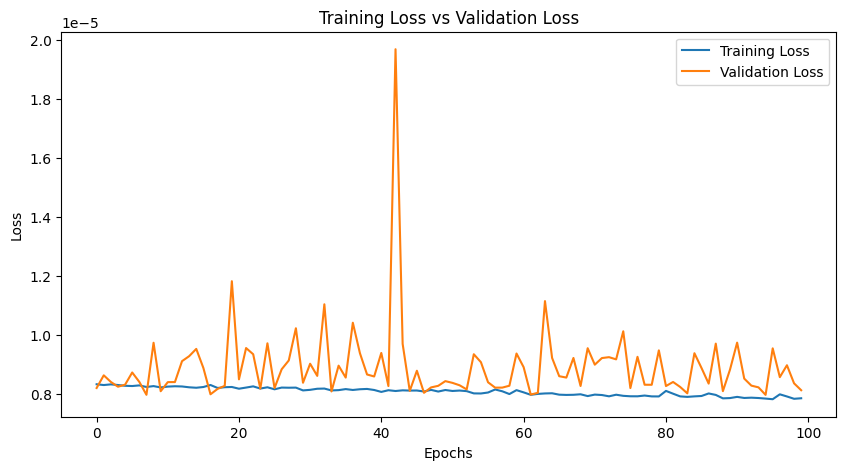

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=100, save_path='model_GRU.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()  # Ensure model is in training mode
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Start the evaluation phase
        model.eval()  # Switch to evaluation mode
        total_valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        validation_losses.append(avg_valid_loss)

        print(f'Epoch {epoch+1}: Training Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}')

    # Save the model after training
    torch.save(model.state_dict(), save_path)

    # Plot Training vs Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.show()

# Prepare data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=True)

# Train the model
train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100)
# Load Model Function
def load_model(model, load_path='model_GRU.pth'):
    model.load_state_dict(torch.load(load_path))
    model.to('cuda')
    return model


Actual: [-12.751147  33.07825 ], Predicted: [-12.74804   33.079426]
Actual: [-12.925635  33.31286 ], Predicted: [-12.92655  33.31348]
Actual: [-12.832962  33.180943], Predicted: [-12.835041  33.19361 ]
Actual: [-12.741708  33.169395], Predicted: [-12.741978  33.16896 ]
Actual: [-13.044553  33.090206], Predicted: [-13.043968  33.089825]
Actual: [-12.866535  33.28155 ], Predicted: [-12.867996  33.277   ]
Actual: [-12.650365  33.12508 ], Predicted: [-12.645014  33.12886 ]
Actual: [-12.878525  33.220177], Predicted: [-12.877537  33.22369 ]
Actual: [-13.07102   33.115757], Predicted: [-13.066873  33.123222]
Actual: [-12.841283  33.19427 ], Predicted: [-12.838464  33.197063]

Average Loss: 8.116573676226635e-06
 RMSE: 0.057868484407663345


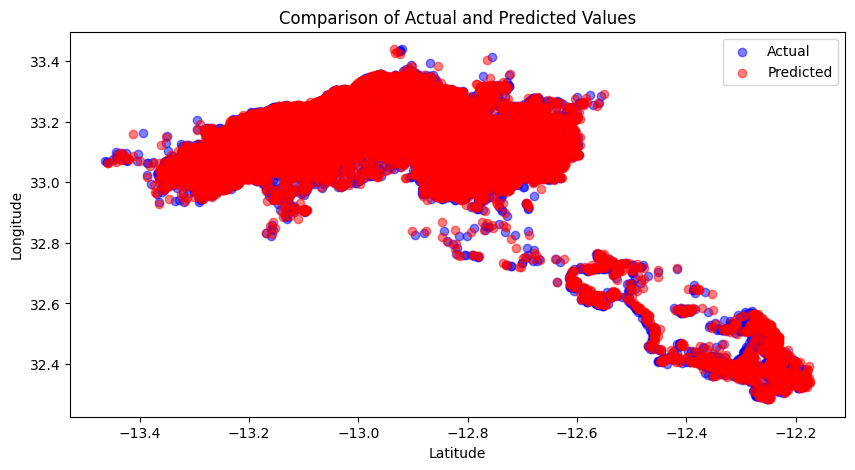

In [22]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model, print actual vs predicted values, and plot them
def evaluate(model, dataloader, criterion, scaler):
    model.eval()
    total_loss = 0
    errors = []
    actuals_list = []
    predicteds_list = []
    sample_count = 0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            # Scale back to original range
            actuals = y_batch.cpu().numpy()
            predicteds = predictions.cpu().numpy()
            min_lat_lon = scaler.data_min_[:2]
            range_lat_lon = scaler.data_range_[:2]
            actuals[:, 0:2] = actuals[:, 0:2] * range_lat_lon + min_lat_lon
            predicteds[:, 0:2] = predicteds[:, 0:2] * range_lat_lon + min_lat_lon

            for actual, predicted in zip(actuals, predicteds):
                actuals_list.append(actual[:2])
                predicteds_list.append(predicted[:2])
                if sample_count < 10:
                    print(f'Actual: {actual[:2]}, Predicted: {predicted[:2]}')
                    sample_count += 1

                # Calculate RMSE for latitude and longitude combined
                error = np.sqrt(np.sum((actual[:2] - predicted[:2])**2))
                errors.append(error)

    avg_loss = total_loss / len(dataloader)
    avg_rmse = np.sqrt(np.mean(errors))

    print(f'\nAverage Loss: {avg_loss}')
    print(f' RMSE: {avg_rmse}')

    # Plotting Actual vs Predicted
    actuals_array = np.array(actuals_list)
    predicteds_array = np.array(predicteds_list)
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals_array[:, 0], actuals_array[:, 1], c='blue', label='Actual', alpha=0.5)
    plt.scatter(predicteds_array[:, 0], predicteds_array[:, 1], c='red', label='Predicted', alpha=0.5)
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Comparison of Actual and Predicted Values')
    plt.legend()
    plt.show()

# Assuming 'model', 'test_loader', 'criterion', and 'scaler' are defined
model = load_model(model)  # Make sure the model is loaded before calling evaluate
evaluate(model, test_loader, criterion, scaler)
